## Imports

In [ ]:
# |default_exp base

In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

In [ ]:
# | hide
# import jupyter_black

# jupyter_black.load()
from stringdale.core import get_git_root, load_env, checkLogs
import pytest

In [ ]:
load_env()

True

In [ ]:
# | export
import os
import sys
import enum
from pathlib import Path
from copy import deepcopy
import itertools
import functools
from enum import Enum
from parse import parse
from typing import Any
from copy import deepcopy,copy


from collections import defaultdict,OrderedDict
from contextlib import ExitStack
from singleton_decorator import singleton

from pprint import pprint
from pydantic import BaseModel
from pydantic_core import SchemaValidator

from typing import Optional,Union,List,Dict,Any,Literal,Callable

import networkx as nx
from networkx.readwrite import json_graph
from fastcore.basics import patch
from tqdm.auto import tqdm
import logging


In [ ]:
#| export
logger = logging.getLogger(__name__)

In [ ]:
#| export
from IPython.display import display,Image,Markdown


In [ ]:
# | export
from pydantic import BaseModel, ConfigDict
from stringdale.core import jinja_render,checkLogs,maybe_await,_duplicates,wrap_exception,NamedLambda
from stringdale.viz import draw_nx,draw_graphviz,display_in_ipython
from stringdale.mappings import (
    parse_edge_descriptor,
    multi_map,
    assert_keys_contiguous,
    access_object,
    map_object,
    object_to_args_kwargs,
)

import inspect
from textwrap import dedent
from parse import parse
import re
import itertools as it
import types
import uuid
import time
import json

## Diagram State

In [ ]:
#| export
from pydantic import BaseModel,ConfigDict,computed_field
from typing import Annotated

In [ ]:
#| export
class BaseModelExtra(BaseModel):
    model_config = ConfigDict(extra='allow')


In [ ]:
#| export
def _is_attr_method(obj,attr):
    if not hasattr(obj,attr):
        return False
    attr_value = getattr(obj,attr)
    return inspect.ismethod(attr_value)

def get_attr_metadata(obj,attr):
    type_fields = obj.model_fields
    if not attr in type_fields:
        return False
    field_info = type_fields[attr]
    if not hasattr(field_info,'metadata'):
        return False
    if len(field_info.metadata) == 0:
        return False
    return field_info.metadata[0]

@wrap_exception("When getting state key {{key}} from state {{state}}:")
def get_state_key(state,key):
    is_key_method = _is_attr_method(state,key)
    if is_key_method:
        return getattr(state,key)()
    else:
        return getattr(state,key)

@wrap_exception("When setting state key {{key}} to {{value}} in state {{state}}:")
def set_state_key(state,key,value):
    is_key_method = _is_attr_method(state,key)
    attr_metadata_func = get_attr_metadata(state,key)
    if is_key_method:
        getattr(state,key)(value)
    elif attr_metadata_func:
        key_state = get_state_key(state,key)
        attr_metadata_func(key_state,value)
    else:
        setattr(state,key,value)


In [ ]:
class RequiredFieldState(BaseModel):
    field:int

In [ ]:
s = RequiredFieldState(field=3)

set_state_key(s,'field',5)
assert s == RequiredFieldState(field=5)

In [ ]:
# a custom state is any basemodel
class CustomState(BaseModel):
    # we can allow arbitrary attributes by setting extra='allow'
    # this is useful for defining on the fly state keys with normal behavior
    model_config = ConfigDict(extra='allow')
    history:list[int] = list()
    _hidden_attribute:str = 'hidden'

    annoated_list: Annotated[list[int],list.append] = list()

    def add_message(self,value):
        self.history.append(value)

    def first_message(self)->int:
        if len(self.history) == 0:
            return 0
        return self.history[0]

    @computed_field
    def last_message(self)->int:
        if len(self.history) == 0:
            return 0
        return self.history[-1]

    @property
    def hidden(self):
        return self._hidden_attribute
    @hidden.setter
    def hidden(self,value):
        self._hidden_attribute = value
    
    
    

In [ ]:
s = CustomState()
s.add_message(3)
s

CustomState(history=[3], annoated_list=[], last_message=3)

In [ ]:
set_state_key(s,'extra_attr',10)
set_state_key(s,'add_message',4)
set_state_key(s,'hidden','different hidden')
set_state_key(s,'annoated_list',5)

In [ ]:
assert get_state_key(s,'last_message') == 4
assert get_state_key(s,'first_message') == 3
assert get_state_key(s,'hidden') == 'different hidden'
assert s.model_dump() == {'history': [3, 4], 'extra_attr': 10, 'last_message': 4,'annoated_list':[5]},s

## Diagram Definition Class

In [ ]:
#| export

class DiagramType(Enum):
    flow = 'flow'
    decision = 'decision'

class DiagramSchema:
    def __init__(self,
        graph = None,
        state_class = BaseModelExtra,
        factored_graph = None,
        start_node = None,
        end_node = None,
        name=None,
        type:DiagramType=None,
        anon=False,
        derive_state=False,
        ):
        """A class representing a diagram schema for computational graphs.

        A Diagram defines a directed graph structure where nodes represent computational steps
        and edges represent data flow between them. 
        and supports validation of graph structure and parallel execution paths.

        Params:
            name (str): Optional name for the diagram schema
            graph (nx.DiGraph): The underlying NetworkX directed graph
            factored_graph (nx.DiGraph, optional): A simplified version of the graph after factorisation,
                where the entire diagram is of a single type.
            start_node (str): Name of the starting node, defaults to 'Start'
            end_node (str): Name of the ending node, defaults to 'End'
            type (DiagramType): The type of diagram (e.g. Flow, Decision)
            anon (bool): Whether this is an anonymous diagram
            derive_state (bool): Whether to derive the state from a calling diagram
            
        """
        self.name = name
        self.graph = graph or nx.DiGraph()
        self.factored_graph = factored_graph
        self.start_node = start_node or 'Start'
        self.end_node = end_node or 'End'
        self.type = type
        self.anon = anon
        self.derive_state = derive_state
        self.state_class = state_class
        self.funcs = dict()

    def __str__(self):
        return f'Diagram({self.name})'

    def __contains__(self,node):
        return node in self.graph.nodes    

    def __getitem__(self,node):
        return self.funcs.get(node,None)

    def __setitem__(self,node,value=None):
        self.funcs[node] = value

    def has_breakpoints(self):
        """Check if diagram contains any breakpoints.
        Returns True if any node has is_break=True or contains a subdiagram with breakpoints.
        """
        graph = self.factored_graph
        for node, data in graph.nodes(data=True):
            # Check if current node is a breakpoint
            if data.get('is_break', False):
                return True
                
            # Check if node contains a subdiagram with breakpoints
            func = self[node]
            if isinstance(func, DiagramSchema) and func.has_breakpoints():
                return True
                
        return False

    @functools.cached_property
    def read_keys(self):
        read_keys = set()
        for node, data in self.graph.nodes(data=True):
            func = self[node]
            if isinstance(func, DiagramSchema):
                read_keys.update(func.read_keys)
        return read_keys

    @functools.cached_property
    def write_keys(self):
        write_keys = set()
        for node, data in self.graph.nodes(data=True):
            func = self[node]
            if isinstance(func, DiagramSchema):
                write_keys.update(func.write_keys)
        return write_keys

In [ ]:
#| export
class Diagram():
    """
    An instance of a stringdale diagram. Instantiated by calling the Schema()

    Has the following public attributes:
    output - the output of the last run
    finished - whether the diagram has reached the End node
    state - the current state of the diagram

    """

    def __init__(self,graph,funcs,type,schema:DiagramSchema,state:BaseModel=None,anon=False,root=None):
        self.graph = graph
        self.funcs = funcs
        self.type = type
        self.state = state
        self.schema = schema
        self.anon = anon
        self.root = root
        self.schema_nodes = list(schema.graph.nodes)
        self.name = schema.name
        self.start_node = schema.start_node
        self.end_node = schema.end_node
        
    def reset(self):
        self.state = None
        self.finished=None
        self.output = None
        self.run_uid = str(uuid.uuid4())

        
        for node in self.graph.nodes:
            if not node in self:
                continue
            func = self[node]
            if isinstance(func,DiagramSchema):
                raise ValueError(f"DiagramSchema nodes are not allowed in a Diagram, they must be instantiated before being added to a Diagram")
            if _is_attr_method(func,'reset'):
                func.reset()

    def get_root(self):
        if self.anon:
            return self.root
        else:
            return self

    def __getitem__(self,key):
        return self.get_root().funcs.get(key,None)  

    def __setitem__(self,key,value):
        self.get_root().funcs[key] = value

    def __contains__(self,key):
        return key in self.get_root().funcs

    def __str__(self):
        return f'Diagram({self.name})@{hex(id(self))}'

    @property
    def attrs_to_serialize(self):
        return ['output','finished','next_node','run_uid']

    def draw(self,
        return_dot=False,
        direction='LR',
        recursive: Union[bool,List[str]]=False,
        factored=False,
        **kwargs
        ):
        return draw_diagram(self.schema,funcs=self.funcs,
            return_dot=return_dot,direction=direction,
            recursive=recursive,factored=factored,**kwargs)  
        

In [ ]:
#| export

@patch
def __call__(self:DiagramSchema,**kwargs):
    
    # make a copy of the graph
    graph = self.graph.copy()
    # and funcs
    funcs = self.funcs.copy()
    funcs = funcs | kwargs
    # reset stateful functions
    for node,func in funcs.items():
        if _is_attr_method(func,'reset'):
            funcs[node] = deepcopy(func)
            funcs[node].reset()

    instance = Diagram(graph=self.factored_graph,funcs=funcs,type=self.type,schema=self)

    for node,func in list(funcs.items()):
        if isinstance(func,DiagramSchema):
            is_schema_anon = func.anon
            func = func()
            func.anon = is_schema_anon
            func.root = instance
            instance.funcs[node] = func
    
    # init running state
    instance.reset()
    return instance 

In [ ]:
#| export
@patch
def get_input_only_state_keys(self:DiagramSchema):
    nodes = self.graph.nodes
    input_state_keys = set()
    output_state_keys = set()
    for node in nodes:
        for key,port in nodes[node].get('read_state',{}).items():
            input_state_keys.add(key)
        for key,port in nodes[node].get('write_state',{}).items():
            output_state_keys.add(key)

    input_only_state_keys = input_state_keys - output_state_keys
    return input_only_state_keys


In [ ]:
g = nx.DiGraph()
g.add_nodes_from([
    ('Start', {}),
    ('End', {}),
    ('Process4', {'is_break':True}),
    ('Process1', {'write_state': {'result':{0:('.',)}}}),
    ('Process2', {'for_each':[0]}),
    ('Process3', {}),
    ('identity', {'for_each':['x'],'read_state':{'result':{'input':('.',)}}}),
])
g.add_edges_from([  #TODO from here
    ('Start','Process1',{'type':DiagramType.decision,
                         'condition':NamedLambda('is_even',lambda x: x%2==0),
                         }),
    ('Process1','Process2',{'type':DiagramType.flow}),
    ('Process1','Process3',{'type':DiagramType.flow}),
    ('Process2','identity',{'type':DiagramType.flow,'mapping':{'x':('a',)}}),
    ('Process3','identity',{'type':DiagramType.flow,'mapping':{'y':('b',)}}),
    ('Start','Process4',{'type':DiagramType.decision}),
    ('Process4','End',{'type':DiagramType.decision,'mapping':{'**':('a',)}}),
    ('identity','End',{'type':DiagramType.decision}),
])



funcs = {
    'Process1':NamedLambda('add1',lambda x: x+1),
    'Process2':NamedLambda('add2',lambda x: x+2),
    'Process3':NamedLambda('add5',lambda x: x+5),
}

TestDef = DiagramSchema(graph=g,name='TestDef')
for node,func in funcs.items():
    TestDef[node] = func


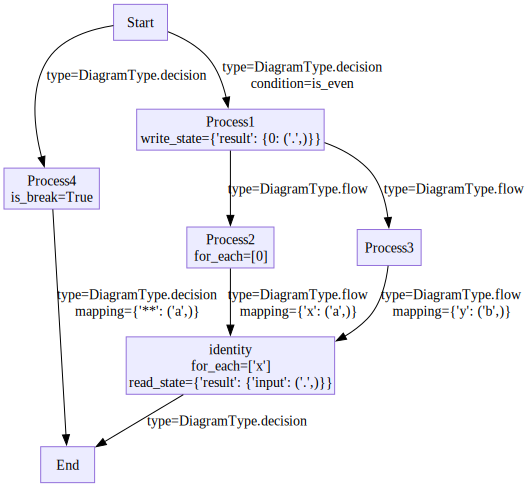

In [ ]:
draw_nx(TestDef.graph)

## Drawing diagrams

In [ ]:
#| export
from textwrap import indent
import re

In [ ]:
#| export
import ast
import inspect
import re

def _get_lambda_source(lambda_func):
    try:
        # Get the complete source lines containing the lambda
        source = inspect.getsource(lambda_func)
        
        # Find the lambda definition using regex
        lambda_match = re.search(r'(lambda\s+[^:]+:[^,\n\]})]+)', source)
        if lambda_match:
            lambda_str = lambda_match.group(1)
            
            # Validate and clean the lambda string using ast
            try:
                ast.parse(lambda_str)
                # Strip 'lambda' and whitespace around parameters
                lambda_str = re.sub(r'lambda\s+', '', lambda_str)
                return lambda_str
            except SyntaxError:
                pass
                
    except Exception:
        pass
    
    return 'Unparseable lambda'

In [ ]:
#| export

def _get_func_name(func):
    if isinstance(func,(types.FunctionType,types.MethodType)):
        if func.__name__ == '<lambda>':
            return _get_lambda_source(func)
        if hasattr(func,'__qualname__'):
            return func.__qualname__
        if hasattr(func,'__name__'):
            return func.__name__
    else:
        return str(func)

def _get_step_name(node_name,data,func=None):
    description_parts = []
    if func is not None:
        description_parts.append(_get_func_name(func))
    if 'for_each' in data:
        description_parts.append(f'foreach=[{", ".join(map(str,data["for_each"]))}]')
    if 'filter' in data:
        description_parts.append('filter=True')
    if 'flat' in data:
        description_parts.append('flat=True')

    description = ', '.join(description_parts)
    if len(description) > 0:
        description = f'[ {description} ]'
    return f'{node_name}{description}'


def _accessor_to_string(accessor):
    if accessor is None:
        return ''
    return f'.'.join([str(acc) for acc in accessor])

def _mapping_to_string(mapping):
    if mapping == {0:('.',)}:
        return ''
    return ', '.join([f'{_accessor_to_string(v)} -> {k}' for k,v in mapping.items()])

def _condition_to_string(condition):
    if condition is None:
        return ''
    return f'?({_get_func_name(condition)})'

def _get_edge_string(u,v,data,mapping):
    condition = data.get('condition',None)
    mapping_string = _mapping_to_string(mapping)
    condition_string = _condition_to_string(condition)

    if len(mapping_string)> 0 and len(condition_string) > 0:
        condition_string += ': '

    if len(mapping_string) == 0 and len(condition_string) == 0:
        return None

    return f'{condition_string}{mapping_string}'




In [ ]:
#| export 


class NodeMapper():
    def __init__(self):
        self.counter = itertools.count()
        self.item_to_id = {}

    def __getitem__(self,item):
        if item not in self.item_to_id:
            self.item_to_id[item] = f'node_{next(self.counter)}'
        return self.item_to_id[item]    

    def __contains__(self,item):
        return item in self.item_to_id

In [ ]:
#| export
def _diagram_to_graphviz_data(g,funcs):
    
    node_mapper = NodeMapper()
    node_data_list = []
    edge_data_list = []

    for node,data in g.nodes(data=True):
        node_id = node_mapper[node]
        func = funcs.get(node,None)
        step_description = _get_step_name(node,data,func)
        is_break = data.get('is_break',False)
        is_stream = len(data.get('for_each',[])) > 0

        style = 'solid,filled'
        if is_break:
            style = 'dashed,filled'
        elif is_stream:
            style = 'bold,filled'

        node_data= {
            'name': node_id,
            'label': step_description,
            'shape': 'box',
            'style': style,
        }

        node_data_list.append(node_data)

        for key,mapping in data.get('read_state', {}).items():
            state_edge_name = _mapping_to_string(mapping)

            state_node_name = f'state_{key}'
            new_state = not state_node_name in node_mapper
            state_node_id = node_mapper[state_node_name]
            if new_state:
                node_data_list.append({
                    'name': state_node_id,
                    'label': f'State[{key}]',
                    'shape': 'cylinder',
                    'style': 'solid,filled',
                })
            edge_data_list.append({
                'tail_name': state_node_id,
                'head_name': node_id,
                'label': state_edge_name,
                'style': 'dashed',
            })
                
        
        for key,mapping in data.get('write_state', {}).items():
            state_edge_name = _mapping_to_string(mapping)

            state_node_name = f'state_{key}'
            new_state = not state_node_name in node_mapper
            state_node_id = node_mapper[state_node_name]
            if new_state:
                node_data_list.append({
                    'name': state_node_id,
                    'label': f'State[{key}]',
                    'shape': 'cylinder',
                    'style': 'solid,filled',
                })
            edge_data_list.append({
                'tail_name': node_id,
                'head_name': state_node_id,
                'label': state_edge_name,
                'style': 'dashed',
            })


    for u,v,data in g.edges(data=True):
        edge_mapping = data.get('mapping',{0:('.',)})
        edge_name = _get_edge_string(u,v,data,edge_mapping)
        
        if data['type'] == DiagramType.flow:
            style = 'solid'
            color = 'black'
        else:
            style = 'bold'
            color = 'blue'
        edge_data_list.append({
            'tail_name': node_mapper[u],
            'head_name': node_mapper[v],
            'label': edge_name,
            'style': style,
            'color': color,
        })
    
    return node_data_list,edge_data_list
    

In [ ]:
node_data_list,edge_data_list = _diagram_to_graphviz_data(TestDef.graph,funcs=TestDef.funcs)
node_data_list,edge_data_list


([{'name': 'node_0',
   'label': 'Start',
   'shape': 'box',
   'style': 'solid,filled'},
  {'name': 'node_1', 'label': 'End', 'shape': 'box', 'style': 'solid,filled'},
  {'name': 'node_2',
   'label': 'Process4',
   'shape': 'box',
   'style': 'dashed,filled'},
  {'name': 'node_3',
   'label': 'Process1[ add1 ]',
   'shape': 'box',
   'style': 'solid,filled'},
  {'name': 'node_4',
   'label': 'State[result]',
   'shape': 'cylinder',
   'style': 'solid,filled'},
  {'name': 'node_5',
   'label': 'Process2[ add2, foreach=[0] ]',
   'shape': 'box',
   'style': 'bold,filled'},
  {'name': 'node_6',
   'label': 'Process3[ add5 ]',
   'shape': 'box',
   'style': 'solid,filled'},
  {'name': 'node_7',
   'label': 'identity[ foreach=[x] ]',
   'shape': 'box',
   'style': 'bold,filled'}],
 [{'tail_name': 'node_3',
   'head_name': 'node_4',
   'label': '',
   'style': 'dashed'},
  {'tail_name': 'node_4',
   'head_name': 'node_7',
   'label': '. -> input',
   'style': 'dashed'},
  {'tail_name': 'no

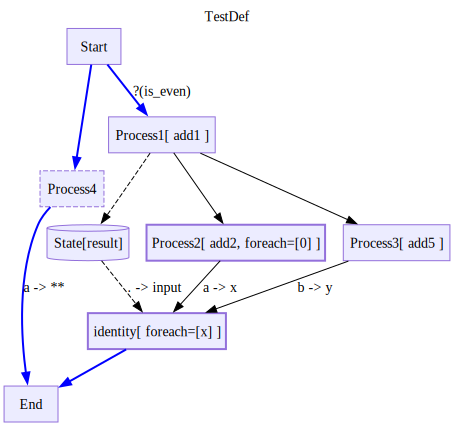

In [ ]:
dot = draw_graphviz(node_data_list,edge_data_list,
    name=TestDef.name,direction='TB',
    node_attrs={'shape':'box','color':'#9370DB','fillcolor':'#ECECFF','style':'filled'}
    ,edge_attrs={},graph_attrs={})
dot

In [ ]:
#| export
def diagram_to_dot(graph,name,funcs,direction='TB',**kwargs):
    
    node_data_list,edge_data_list = _diagram_to_graphviz_data(graph,funcs=funcs)
    dot = draw_graphviz(node_data_list,edge_data_list,
        name=name,direction=direction,
        node_attrs={'shape':'box','color':'#9370DB','fillcolor':'#ECECFF'}
        ,edge_attrs={},graph_attrs={},**kwargs)
    return dot

def _match_any(name,patterns):
    for pattern in patterns:
        if re.match(pattern,name):
            return True
    return False


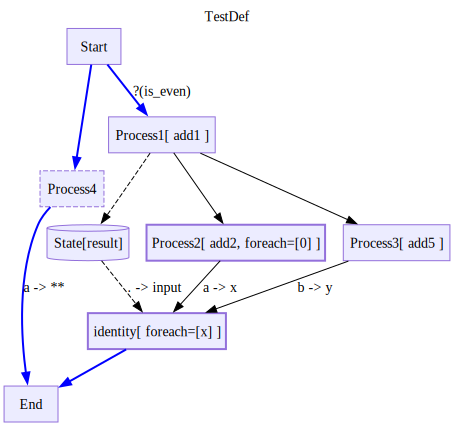

In [ ]:
diagram_to_dot(TestDef.graph,TestDef.name,TestDef.funcs)

In [ ]:
#| export

def get_recursive_diagrams(diagram,funcs,recursive: Union[bool,List[str]]=False,factored=False):

    if isinstance(diagram,Diagram):
        diagram = diagram.schema
    diagrams_to_draw = [(diagram,funcs)]
    if recursive is True:
        recursive = ['.*']
    elif recursive is False:
        recursive = []

    if factored or recursive:
        for node in diagram.factored_graph.nodes():
            func = funcs.get(node,None)
            if isinstance(func,(DiagramSchema,Diagram)):
                should_draw = _match_any(node,recursive) or (factored and func.anon)
            else:
                continue
            if should_draw:
                sub_d = func
                if sub_d.anon:
                    funcs = funcs
                else:
                    funcs = sub_d.funcs
                diagrams_to_draw.extend(get_recursive_diagrams(sub_d,funcs,recursive,factored))
    return diagrams_to_draw
        

def draw_diagram(diagram,
    return_dot=False,
    direction='LR',
    recursive: Union[bool,List[str]]=False,
    factored=False,
    funcs=None,
    **kwargs
    ):
    """Draw a DiagramSchema using graphviz.
    
    
    Args:
        diagram: Either a diagram object or a diagram scheme object
        name: If provided, uses this name for the diagram in the Mermaid title
        return_dot: If True, returns the graphviz dot object
        direction: direction to draw, either TB (top to bottom) or LR (left to right), defaults to TB
        recursive: Whether to draw subdiagrams as well. 
            If False, only the top level diagram is drawn.
            If True, all subdiagrams are drawn.
            If a list of strings, only the subdiagrams with whose names the regex strings are drawn.
        factored: If True, draws the factored graph, used for debugging
    Returns:
        If return_dot is True, returns dot objects
        Otherwise displays diagram when in an Ipython environment
       
    """

    default_kwargs = {
        'width':20,
        'break_long_words':False,
        'replace_whitespace':False,
    }
    if funcs is None:
        funcs = diagram.funcs
    
    diagrams_to_draw = get_recursive_diagrams(diagram,funcs,recursive,factored)
    # TODO maybe return pairs of diagrams and funcs?
    dot_per_diagram = {}
    for diagram,funcs in diagrams_to_draw:
        if factored:
            dot_per_diagram[diagram.name] = diagram_to_dot(diagram.factored_graph,diagram.name,funcs,direction=direction,**(default_kwargs|kwargs))
        else:
            dot_per_diagram[diagram.name] = diagram_to_dot(diagram.graph,diagram.name,funcs,direction=direction,**(default_kwargs|kwargs))
    
    if return_dot:
        if recursive or factored:
            return dot_per_diagram
        else:
            return list(dot_per_diagram.values())[0]
        
    for name,dot in dot_per_diagram.items():
        display_in_ipython(dot)

@patch
def draw(self:DiagramSchema,
    return_dot=False,
    direction='LR',
    recursive: Union[bool,List[str]]=False,
    factored=False,
    **kwargs
    ):
    """Draw a DiagramSchema using graphviz.
    
    
    Args:
        diagram: Either a diagram object or a diagram scheme object
        name: If provided, uses this name for the diagram in the Mermaid title
        return_dot: If True, returns the graphviz dot object
        direction: direction to draw, either TB (top to bottom) or LR (left to right), defaults to TB
        recursive: Whether to draw subdiagrams as well. 
            If False, only the top level diagram is drawn.
            If True, all subdiagrams are drawn.
            If a list of strings, only the subdiagrams with whose names the regex strings are drawn.
        factored: If True, draws the factored graph, used for debugging
    Returns:
        If return_dot is True, returns dot objects
        Otherwise displays diagram when in an Ipython environment
       
    """
    return draw_diagram(self,return_dot=return_dot,direction=direction,recursive=recursive,factored=factored,**kwargs)
    

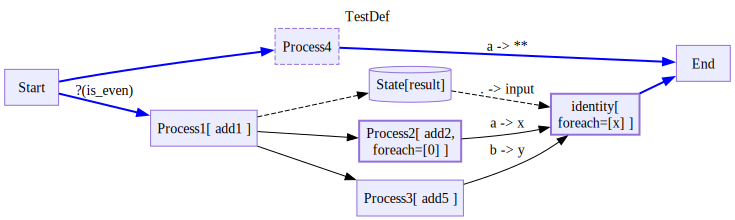

In [ ]:
TestDef.draw()

## Factoring diagrams into nested single type diagrams

## Running unit test

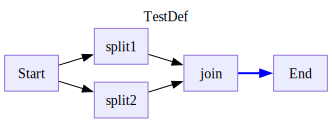

In [ ]:
g = nx.DiGraph()
g.add_nodes_from([
    ('Start', {}),
    ('End', {}),
    ('split1', {}),
    ('split2', {}),
    ('join', {}),
])
g.add_edges_from([  
    ('Start','split1',{'type':DiagramType.flow}),
    ('Start','split2',{'type':DiagramType.flow}),
    ('split1','join',{'type':DiagramType.flow}),
    ('split2','join',{'type':DiagramType.flow}),
    ('join','End',{'type':DiagramType.decision}),
    
])


A = DiagramSchema(graph=g,name='TestDef')

A.draw()


### nx utils

In [ ]:
#| export


def _get_reachable_nodes(graph,node,reversed=False,bidirectional=False):
    if bidirectional:
        undirected_graph = graph.to_undirected()
        return set(nx.descendants(undirected_graph,node)).union({node})
    if reversed:
        return set(nx.ancestors(graph,node)).union({node})
    else:
        return set(nx.descendants(graph,node)).union({node})

def _replace_subgraph_with_node(g,subgraph,node_name,node_attrs=None):
    if node_attrs is None:
        node_attrs = {}
    g.add_node(node_name,**node_attrs)
    # if there is an edge from a node in subgraph to a node not in subgraph, add an edge from node_name to that node    
    for u,v,d in list(g.edges(data=True)):
        if u in subgraph.nodes() and v not in subgraph.nodes():
            g.add_edge(node_name,v,**d)
        elif v in subgraph.nodes() and u not in subgraph.nodes():
            g.add_edge(u,node_name,**d)
        
        # self edges between nodes in the subgraph that are not part of the subgraph, ie the subgraph is a self loop
        elif u in subgraph.nodes() and v in subgraph.nodes() and (u,v) not in subgraph.edges():
            g.add_edge(node_name,node_name,**d)
    
    # remove all edges in subgraph
    g.remove_nodes_from(list(subgraph.nodes()))
    return g


### Subdir utils

In [ ]:
#| export 

from functools import lru_cache

In [ ]:
#| export
def _assert_single_edge_type(graph,node):
    in_edge_types = set(d['type'] for u,v,d in graph.in_edges(node,data=True))
    out_edge_types = set(d['type'] for u,v,d in graph.out_edges(node,data=True))
    if len(in_edge_types) > 1 or len(out_edge_types) > 1:
        raise ValueError(f"Node {node} has multiple edge types: in edge types '{in_edge_types}' and out edge types '{out_edge_types}'")

def _get_edge_type(graph,node,input_edge=False,output_edge=False):
    if input_edge:
        edges_data = [d for u,v,d in graph.in_edges(node,data=True)]
    elif output_edge:
        edges_data = [d for u,v,d in graph.out_edges(node,data=True)]
    if len(edges_data) == 0:
        return None
    return edges_data[0]['type']

def _has_different_edge_type(graph,node,edge_type,input_edge=False,output_edge=False):
    node_edge_type = _get_edge_type(graph,node,input_edge=input_edge,output_edge=output_edge)
    if node_edge_type is None:
        return False
    else:
        return node_edge_type != edge_type


def _subgraph_by_edge_type(graph,edge_type):
    return nx.edge_subgraph(graph,[(u,v) for u,v,d in graph.edges(data=True) if d['type'] == edge_type])


In [ ]:
#| export

def _different_edge_types(graph,node):
    return _get_edge_type(graph,node,input_edge=True) != _get_edge_type(graph,node,output_edge=True)

def _get_sub_sources(g):
    # a sub source is a node with no incoming edges, or one where the type of all incoming edges and the type of outgoing edges are different.
    for node in g.nodes():
        has_no_outgoing_edges = len(list(g.out_edges(node))) == 0
        different_in_out_edge_types = _different_edge_types(g,node)
        if different_in_out_edge_types and not has_no_outgoing_edges:
            yield node

def _get_sub_sinks(g):
    # a sub sink is a node with no outgoing edges, or one where the type of all outgoing edges and the type of incoming edges are different.
    for node in g.nodes():
        has_no_incoming_edges = len(list(g.in_edges(node))) == 0
        different_out_in_edge_types = _different_edge_types(g,node)
        if different_out_in_edge_types and not has_no_incoming_edges:
            yield node



In [ ]:
g = A.graph

sources = set(_get_sub_sources(g))
sinks = set(_get_sub_sinks(g))
assert sources == {'Start','join'},sources
assert sinks == {'End','join'},sinks


In [ ]:
#| export
def _spanned_sub_diagram(g,source):
    # the spanned sub diagram is the subgraph of g that is reachable from the source node when induced on the outgoing edge type of the source node.
    edge_type = _get_edge_type(g,source,output_edge=True)
    edge_type_sub_g = _subgraph_by_edge_type(g,edge_type)
    spanned_nodes = _get_reachable_nodes(edge_type_sub_g,source)
    spanned_sub_g = edge_type_sub_g.subgraph(spanned_nodes)
    return spanned_sub_g

def _is_diagram_simple(g):
    # a diagram is simple if it has a single source and a single sink and all paths between them have a single edge type.
    sources = list(_get_sub_sources(g))
    sinks = list(_get_sub_sinks(g))
    if len(sources) != 1 or len(sinks) != 1:
        return False

    source = sources[0]
    sink = sinks[0]

    reachable_from_source = _get_reachable_nodes(g,source)
    
    if sink not in reachable_from_source:
        return False
    
    return set(g.nodes()) == reachable_from_source



source: Start, nodes: ['Start', 'split1', 'split2', 'join'], edges: [('Start', 'split1'), ('Start', 'split2'), ('split1', 'join'), ('split2', 'join')]
is simple: True


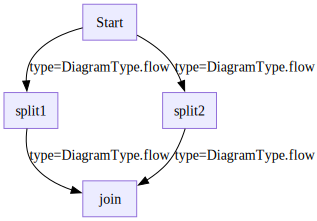

source: join, nodes: ['End', 'join'], edges: [('join', 'End')]
is simple: True


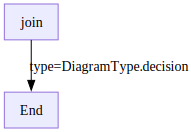

In [ ]:
spanned_sub_diagrams = {source:_spanned_sub_diagram(g,source) for source in sources}
is_simple = {source: _is_diagram_simple(spanned_sub_diagrams[source]) for source in sources}

sources,sinks,spanned_sub_diagrams,is_simple
for source,sub_diagram in spanned_sub_diagrams.items():
    print(f'source: {source}, nodes: {list(sub_diagram.nodes())}, edges: {list(sub_diagram.edges())}')
    print(f'is simple: {is_simple[source]}')
    draw_nx(sub_diagram)

In [ ]:
#| export
def _compress_sub_diagram(g,funcs,subgraph,source,sink):
    # makes a new anon diagram from the subgraph, with the source and sink as the start and end nodes.
    sub_dir_name = f'anon_from_{source}_to_{sink}'
    s = deepcopy(subgraph)
    edge_type = _get_edge_type(g,source,output_edge=True)
    sub_dir = DiagramSchema(name=sub_dir_name,
        graph=s,
        factored_graph=s,
        start_node=source,
        end_node=sink,
        type=edge_type,
        anon=True)
    # removes the subgraph from the graph, replaces it with the new node.
    g = _replace_subgraph_with_node(g,subgraph,sub_dir_name)
    # add the new node to the funcs dictionary
    funcs[sub_dir_name] = sub_dir
    return g,funcs



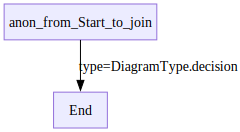

{'anon_from_Start_to_join': <__main__.DiagramSchema>}

In [ ]:
g = deepcopy(A.graph)
funcs = deepcopy(A.funcs)

g_tag,funcs_tag = _compress_sub_diagram(g,funcs,spanned_sub_diagrams['Start'],'Start','join')
draw_nx(g_tag)
funcs


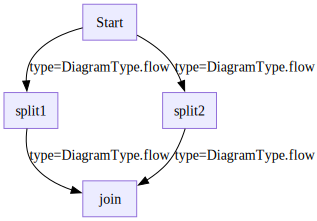

In [ ]:
draw_nx(funcs['anon_from_Start_to_join'].factored_graph)

In [ ]:
#| export
from itertools import product

In [ ]:
#| export 
def factor_graph(g,funcs):
    """
    Given a graph of a diagram schemas, and a dictionary of functions, factor the graph into a nested simple diagrams.
    Return a new nested graph with the new diagram schemas in the funcs dictionary.
    """
    orig_g = g
    g = deepcopy(g)

    while True:
        logger.debug(f"Factoring graph\n"
                    f"nodes {list(g.nodes())}\n"
                    f"edges {list(g.edges())}\n")    
        

        
        sources = list(_get_sub_sources(g))
        sinks = list(_get_sub_sinks(g))
        spanned_sub_diagrams = {source:_spanned_sub_diagram(g,source) for source in sources}
        is_simple = {source: _is_diagram_simple(spanned_sub_diagrams[source]) for source in sources}
        compressed_g = None

        if _is_diagram_simple(g):
            logger.debug("Graph is simple, breaking")
            break
        
        nodes_per_spanned_sub_diagram = {source:list(spanned_sub_diagrams[source].nodes()) for source in sources}
        logger.debug(f"Sources: {sources}")
        logger.debug(f"Sinks: {sinks}")
        logger.debug(f"Spanned sub diagrams: {nodes_per_spanned_sub_diagram}")
        logger.debug(f"Is simple: {is_simple}")

        # sort sources by the number of nodes in the spanned sub diagram, and then by the source name
        sorted_sources = sorted(sources, key=lambda x: (len(spanned_sub_diagrams[x].nodes()),x),reverse=True)

        for source,sink in product(sorted_sources,sinks):
            if source == sink:
                continue
            if sink in spanned_sub_diagrams[source].nodes() and is_simple[source]:
                logger.debug(f"Compressing subdiagram from {source} to {sink}")
                compressed_g,funcs = _compress_sub_diagram(g,funcs,spanned_sub_diagrams[source],source,sink)
                break
                
        if compressed_g is None:
            raise ValueError(f"No simple subdiagram found though the graph is not simple for g with:\n"
                             f"nodes {list(g.nodes())}\n"
                             f"edges {list(g.edges())}\n"
                             )
        g = compressed_g
    

    source = sources[0]
    sink = sinks[0]
    new_type = _get_edge_type(g,source,output_edge=True)
    
    return g,funcs,new_type,source,sink

                    
                    

In [ ]:
#| export
@patch
def factor_diagram(self:DiagramSchema):
    try:
        factored_g,new_funcs,new_type,source,sink = factor_graph(self.graph,self.funcs)
    except Exception as e:
        raise ValueError(f"Compound Diagram could not be reduced to simple diagrams. Make sure all nested scopes have a single entry and exit point.")
    self.factored_graph = factored_g
    self.type = new_type
    self.funcs = new_funcs
    self.start_node = source
    self.end_node = sink

    for node,func in new_funcs.items():
        if isinstance(func,DiagramSchema) and func.anon:
            func.root_diagram = self
    return self

## Draw factored tests

In [ ]:
from stringdale.viz import draw_nx

### Sequence of diagrams

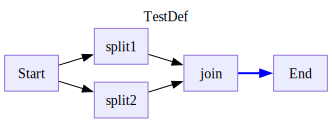

In [ ]:
g = nx.DiGraph()
g.add_nodes_from([
    ('Start', {}),
    ('End', {}),
    ('split1', {}),
    ('split2', {}),
    ('join', {}),
])
g.add_edges_from([  
    ('Start','split1',{'type':DiagramType.flow}),
    ('Start','split2',{'type':DiagramType.flow}),
    ('split1','join',{'type':DiagramType.flow}),
    ('split2','join',{'type':DiagramType.flow}),
    ('join','End',{'type':DiagramType.decision}),
    
])


A = DiagramSchema(graph=g,name='TestDef')

A.draw()


In [ ]:
with checkLogs():
    A.factor_diagram()

__main__ - DEBUG - Factoring graph
nodes ['Start', 'End', 'split1', 'split2', 'join']
edges [('Start', 'split1'), ('Start', 'split2'), ('split1', 'join'), ('split2', 'join'), ('join', 'End')]

__main__ - DEBUG - Sources: ['Start', 'join']
__main__ - DEBUG - Sinks: ['End', 'join']
__main__ - DEBUG - Spanned sub diagrams: {'Start': ['Start', 'split1', 'split2', 'join'], 'join': ['End', 'join']}
__main__ - DEBUG - Is simple: {'Start': True, 'join': True}
__main__ - DEBUG - Compressing subdiagram from Start to join
__main__ - DEBUG - Factoring graph
nodes ['End', 'anon_from_Start_to_join']
edges [('anon_from_Start_to_join', 'End')]

__main__ - DEBUG - Graph is simple, breaking


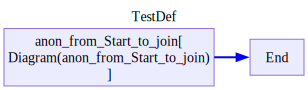

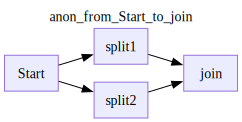

In [ ]:
A.draw(factored=True)

### loop

In [ ]:
class Adder():
    def __init__(self,x):
        self.x = x

    def __call__(self,y):
        return self.x + y

    def __repr__(self):
        return f'Adder({self.x})'

sum = NamedLambda('sum',sum)

is112 = NamedLambda('is112',lambda x: x == 112)

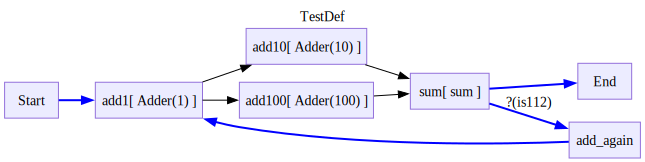

In [ ]:
g = nx.DiGraph()
g.add_nodes_from([
    ('Start', {}),
    ('End', {}),
    ('add1', {}),
    ('add10', {}),
    ('add100', {}),
    ('sum', {}),
    ('add_again', {}),
])
g.add_edges_from([  
    ('Start','add1',{'type':DiagramType.decision}),
    ('add1','add10',{'type':DiagramType.flow}),
    ('add1','add100',{'type':DiagramType.flow}),
    ('add10','sum',{'type':DiagramType.flow}),
    ('add100','sum',{'type':DiagramType.flow}),
    ('sum','End',{'type':DiagramType.decision}),
    ('sum','add_again',{'type':DiagramType.decision,'condition':is112}),
    ('add_again','add1',{'type':DiagramType.decision}),
])

funcs = {
    'add1':Adder(1),
    'add10':Adder(10),
    'add100':Adder(100),
    'sum':sum,
}

A = DiagramSchema(graph=g,name='TestDef')
for node,func in funcs.items():
    A[node] = func

A.draw()


In [ ]:
with checkLogs():
    A.factor_diagram()

__main__ - DEBUG - Factoring graph
nodes ['Start', 'End', 'add1', 'add10', 'add100', 'sum', 'add_again']
edges [('Start', 'add1'), ('add1', 'add10'), ('add1', 'add100'), ('add10', 'sum'), ('add100', 'sum'), ('sum', 'End'), ('sum', 'add_again'), ('add_again', 'add1')]

__main__ - DEBUG - Sources: ['Start', 'add1', 'sum']
__main__ - DEBUG - Sinks: ['End', 'add1', 'sum']
__main__ - DEBUG - Spanned sub diagrams: {'Start': ['Start', 'add1'], 'add1': ['add1', 'add10', 'add100', 'sum'], 'sum': ['End', 'add1', 'sum', 'add_again']}
__main__ - DEBUG - Is simple: {'Start': True, 'add1': True, 'sum': False}
__main__ - DEBUG - Compressing subdiagram from add1 to sum
__main__ - DEBUG - Factoring graph
nodes ['Start', 'End', 'add_again', 'anon_from_add1_to_sum']
edges [('Start', 'anon_from_add1_to_sum'), ('add_again', 'anon_from_add1_to_sum'), ('anon_from_add1_to_sum', 'End'), ('anon_from_add1_to_sum', 'add_again')]

__main__ - DEBUG - Graph is simple, breaking


In [ ]:
A.funcs

{'add1': Adder(1),
 'add10': Adder(10),
 'add100': Adder(100),
 'sum': sum,
 'anon_from_add1_to_sum': <__main__.DiagramSchema>}

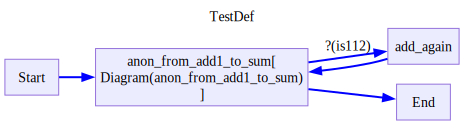

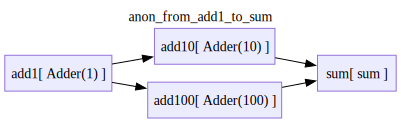

In [ ]:
A.draw(factored=True)


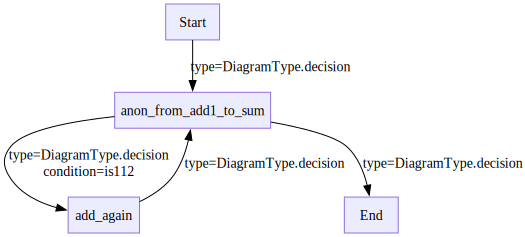

In [ ]:
draw_nx(A.factored_graph)


## Multiple factoring

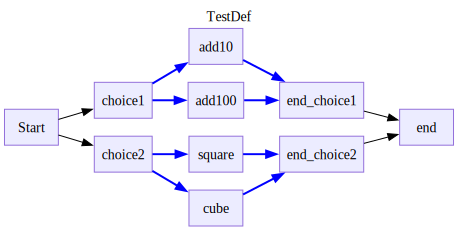

In [ ]:
g = nx.DiGraph()

g.add_edges_from([  
    ('Start','choice1',{'type':DiagramType.flow}),
    ('Start','choice2',{'type':DiagramType.flow}),
    ('end_choice1','end',{'type':DiagramType.flow}),
    ('end_choice2','end',{'type':DiagramType.flow}),
    ('choice1','add10',{'type':DiagramType.decision}),
    ('choice1','add100',{'type':DiagramType.decision}),
    ('add10','end_choice1',{'type':DiagramType.decision}),
    ('add100','end_choice1',{'type':DiagramType.decision}),
    ('choice2','square',{'type':DiagramType.decision}),
    ('choice2','cube',{'type':DiagramType.decision}),
    ('square','end_choice2',{'type':DiagramType.decision}),
    ('cube','end_choice2',{'type':DiagramType.decision}),
    
])

A = DiagramSchema(graph=g,name='TestDef')
A.draw()


In [ ]:
with checkLogs():
    A.factor_diagram()


__main__ - DEBUG - Factoring graph
nodes ['Start', 'choice1', 'choice2', 'end_choice1', 'end', 'end_choice2', 'add10', 'add100', 'square', 'cube']
edges [('Start', 'choice1'), ('Start', 'choice2'), ('choice1', 'add10'), ('choice1', 'add100'), ('choice2', 'square'), ('choice2', 'cube'), ('end_choice1', 'end'), ('end_choice2', 'end'), ('add10', 'end_choice1'), ('add100', 'end_choice1'), ('square', 'end_choice2'), ('cube', 'end_choice2')]

__main__ - DEBUG - Sources: ['Start', 'choice1', 'choice2', 'end_choice1', 'end_choice2']
__main__ - DEBUG - Sinks: ['choice1', 'choice2', 'end_choice1', 'end', 'end_choice2']
__main__ - DEBUG - Spanned sub diagrams: {'Start': ['Start', 'choice1', 'choice2'], 'choice1': ['add100', 'add10', 'end_choice1', 'choice1'], 'choice2': ['square', 'cube', 'end_choice2', 'choice2'], 'end_choice1': ['end_choice1', 'end'], 'end_choice2': ['end', 'end_choice2']}
__main__ - DEBUG - Is simple: {'Start': False, 'choice1': True, 'choice2': True, 'end_choice1': True, 'end

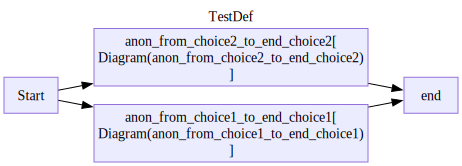

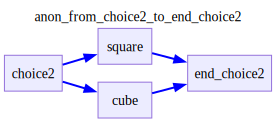

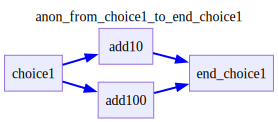

In [ ]:
A.draw(factored=True)

## Validation of diagrams

In [ ]:
#| export

validate_logger = logging.getLogger(f'{__name__}.validate')

def _validate_diagram_unfactored(diagram):
    
    g = diagram.graph

    validate_logger.debug(f"Validating unfactored diagram {diagram.name}")

    def get_father_target_ports(father,node):
        edge_data = g.edges[father,node]
        target_ports = edge_data.get('mapping',{}).keys()
        return list(target_ports)


    # make sure all nodes have a single edge type
    for node,data in g.nodes(data=True):
        _assert_single_edge_type(g,node)

    validate_logger.debug(f"All nodes have a single edge type")

    for node in g.nodes():
        
        input_state_ports = list(g.nodes[node].get('read_state',{}).keys())
        input_edge_type = _get_edge_type(g,node,input_edge=True)

        if input_edge_type == DiagramType.decision:
            for father_node,_,edge_data in g.in_edges(node,data=True):
                father_target_ports = list(edge_data.get('mapping',{}).keys())
                # if there is an overlap between the father_target_ports and the input_state_ports, raise an error
                intersection = set(father_target_ports).intersection(input_state_ports) 
                if intersection:
                    raise ValueError(f"Node {node} has the conflicting input ports '{intersection}' \n"
                                    f" in both its state and its father node {father_node}\n"
                                    )
                union = set(father_target_ports).union(input_state_ports)
                if not assert_keys_contiguous(union):
                    raise ValueError(f"Node {node}'s input key are not contiguos (0,1,2,3... without gaps) when coming from:\n"
                                    f"{father_node} and state\n"
                                    f"The input keys are {union}"
                                    )

        elif input_edge_type == DiagramType.flow:
            # for flow inputs we check all incoming nodes together
            port_set_per_father = {
                'input_state_ports':input_state_ports,
            }
            
            for father,_,edge_data in g.in_edges(node,data=True):
                father_target_ports = list(edge_data.get('mapping',{}).keys())
                port_set_per_father[father] = father_target_ports
            
            duplicate_ports = _duplicates(port_set_per_father.values())
            if len(duplicate_ports) > 0:
                raise ValueError(f"Node {node} has conflicting input ports '{duplicate_ports}'\n"
                                 f"between its father nodes and/or state {port_set_per_father}")
            union = set(input_state_ports)
            for father_ports in port_set_per_father.values():
                union = union.union(set(father_ports))
            if not assert_keys_contiguous(union):
                raise ValueError(f"Node {node}'s input key are not contiguos (0,1,2,3... without gaps) when coming from:\n"
                                f"{port_set_per_father}\n"
                                f"The input keys are {union}"
                                )


    start_node = diagram.start_node
    end_node = diagram.end_node

    if not nx.has_path(g,start_node,end_node):
        raise ValueError(f"Diagram {diagram.name} has no path from start node {start_node} to end node {end_node}")

    no_input_nodes = {node for node in g.nodes() if len(g.in_edges(node)) == 0}
    if no_input_nodes!={start_node}:
        extra_nodes = no_input_nodes-{start_node}
        raise ValueError(f"Diagram {diagram.name} has unreachable nodes with no input edges except for the start node({start_node}): {extra_nodes}")





In [ ]:
# Handling state conflicts
# flow nodes cant write state if they have a non one mutiplicity
# or if there is another node that reads or writes the same state

# for nested anonymous diagrams, where state is shared, we need an ownership mechanism
# each subdiagram has who it reads and writes to, and we need to make sure that there are no multiplicities except multiple readers at once.

# also, we need to figure out how to avoid sharing states between a subdiagram that is used twice in a flow diagram. we need to make copies of the diagram for each one.

# currently, to start, I won't allow writing to shared state within a flow diagram.
# this is done by checking read_keys and write_keys on the unfactored graph

In [ ]:
#|export
def _validate_diagram_factored(diagram):
    graph = diagram.factored_graph
    
    # we keep for each node in the unfactored graph, the nested node in the factored graph
    # it corresponds to.
    nodes_to_nested_nodes = {node:[node] for node in graph.nodes}

    # validate all anonymous subdiagrams recursively
    anon_sub_diagrams = []
    for node,node_data in graph.nodes(data=True):
        func = diagram[node]
        if isinstance(func,DiagramSchema) and func.anon:
            sub_diag_nested_nodes = _validate_diagram_factored(func)

    match diagram.type:
        case DiagramType.flow:
            _validate_flow_diagram(diagram)
        case DiagramType.decision:
            _validate_decision_diagram(diagram)


    # for each node, compute its port mappings dict of the form {'father_node':mapping_dict}
    for node,node_data in graph.nodes(data=True):
        port_mappings = {}
        # regular father mappings
        for father,_,edge_data in graph.in_edges(node,data=True):
            port_mappings[father] = edge_data.get('mapping',{})
        # read state mappings
        for key,mapping in node_data.get('read_state',{}).items():
            port_mappings[('state',key)] = mapping
        node_data['mapping'] = port_mappings
        validate_logger.debug(f"Port mapping for node {node}:{dict(port_mappings)}")



def _validate_flow_diagram(diagram):
    graph = diagram.factored_graph
    if diagram.has_breakpoints():  
        raise ValueError(f"Breakpoints are not allowed in a Flow diagram ({diagram.name})")

    if len(diagram.write_keys) > 0:
        raise ValueError(f"Flow diagrams cannot have write keys, but diagram {diagram.name} has write keys {diagram.write_keys}")

    # make sure that ends of flow diagrams are not mapped, meaning they collect all their inputs
    if graph.nodes[diagram.end_node].get('for_each',list()) != []:
        raise ValueError(f"End node {diagram.end_node} of flow diagram {diagram.name} is cannot have for_each inputs.\n"
                        f"The end of the flow diagram must be a single node that collects all its inputs into a single output")


    # for each node we compute the for_each_fathers. The fathers that have foreach ports
    for node,node_data in graph.nodes(data=True):
        for_each_ports = node_data.get('for_each',list())
        for_each_fathers = set()
        regular_fathers = set()
        for father,_,edge_data in graph.in_edges(node,data=True):
            target_port = edge_data.get('target_port',None)
            if isinstance(target_port,tuple):
                for port in target_port:
                    if port in for_each_ports:
                        for_each_fathers.add(father)
                    else:
                        regular_fathers.add(father)
            else:
                if target_port in for_each_ports:
                    for_each_fathers.add(father)
                else:
                    regular_fathers.add(father)
        node_data['regular_fathers'] = regular_fathers
        node_data['for_each_fathers'] = for_each_fathers


    

def _validate_decision_diagram(diagram):
   
    graph = diagram.factored_graph


    for node,data in graph.nodes(data=True):
        out_edges = list(graph.out_edges(node,data=True))
        edges_without_condition = [ (s,t,d) for s,t,d in out_edges if d.get('condition',None) is None]
        if len(edges_without_condition) > 1:
            clean_edges = [(s,t) for s,t,d, in edges_without_condition]
            raise ValueError(f"In a Decision diagram, Node {node} cannot have multiple output edges with no condition\n"
                            f"Currenlty, edges {clean_edges} do not have a condition.\n")
        
        if node == diagram.end_node:
            continue
        # check that all nodes except the End node have an output edge.
        if len(list(graph.out_edges(node,data=False))) == 0:
            raise ValueError(f"Node {node} must have an output edge, since it is not the end node.\n"
                            f"In diagram {diagram.name}"
            )



## Post Def

In [ ]:
#| export
@patch
def post_def(self:DiagramSchema):
    '''
    validate the graph and factor it
    '''
    logger.debug(f"Post def for diagram {self.name}")
    _validate_diagram_unfactored(self)
    self.factor_diagram()
    _validate_diagram_factored(self)
    


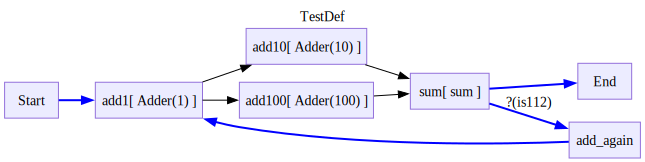

In [ ]:
g = nx.DiGraph()
g.add_nodes_from([
    ('Start', {}),
    ('End', {}),
    ('add1', {}),
    ('add10', {}),
    ('add100', {}),
    ('sum', {}),
    ('add_again', {}),
])
g.add_edges_from([  
    ('Start','add1',{'type':DiagramType.decision}),
    ('add1','add10',{'type':DiagramType.flow}),
    ('add1','add100',{'type':DiagramType.flow}),
    ('add10','sum',{'type':DiagramType.flow}),
    ('add100','sum',{'type':DiagramType.flow}),
    ('sum','End',{'type':DiagramType.decision}),
    ('sum','add_again',{'type':DiagramType.decision,'condition':is112}),
    ('add_again','add1',{'type':DiagramType.decision}),
])

funcs = {
    'add1':Adder(1),
    'add10':Adder(10),
    'add100':Adder(100),
    'sum':sum,
}

A = DiagramSchema(graph=g,name='TestDef')
for node,func in funcs.items():
    A[node] = func

draw_diagram(A)


In [ ]:
with checkLogs():
    A.post_def()

__main__ - DEBUG - Post def for diagram TestDef
__main__.validate - DEBUG - Validating unfactored diagram TestDef
__main__.validate - DEBUG - All nodes have a single edge type
__main__ - DEBUG - Factoring graph
nodes ['Start', 'End', 'add1', 'add10', 'add100', 'sum', 'add_again']
edges [('Start', 'add1'), ('add1', 'add10'), ('add1', 'add100'), ('add10', 'sum'), ('add100', 'sum'), ('sum', 'End'), ('sum', 'add_again'), ('add_again', 'add1')]

__main__ - DEBUG - Sources: ['Start', 'add1', 'sum']
__main__ - DEBUG - Sinks: ['End', 'add1', 'sum']
__main__ - DEBUG - Spanned sub diagrams: {'Start': ['Start', 'add1'], 'add1': ['add1', 'add10', 'add100', 'sum'], 'sum': ['End', 'add1', 'sum', 'add_again']}
__main__ - DEBUG - Is simple: {'Start': True, 'add1': True, 'sum': False}
__main__ - DEBUG - Compressing subdiagram from add1 to sum
__main__ - DEBUG - Factoring graph
nodes ['Start', 'End', 'add_again', 'anon_from_add1_to_sum']
edges [('Start', 'anon_from_add1_to_sum'), ('add_again', 'anon_fro

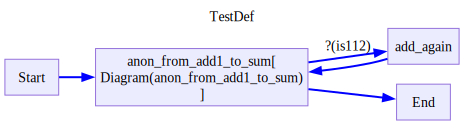

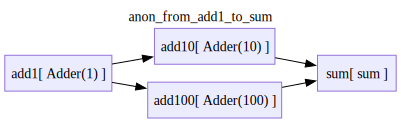

In [ ]:
draw_diagram(A,factored=True)

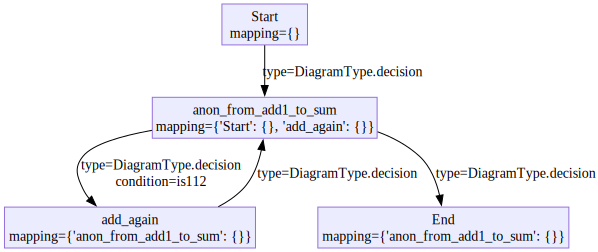

In [ ]:
draw_nx(A.factored_graph)


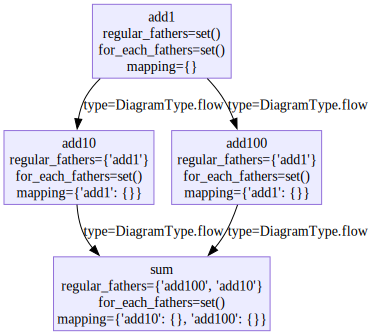

In [ ]:
draw_nx(A.funcs['anon_from_add1_to_sum'].factored_graph)

## Instantiate Diagrams

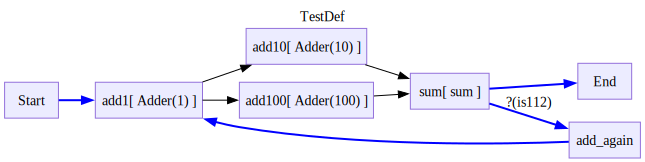

In [ ]:
A.draw()

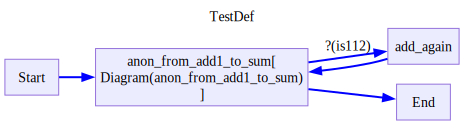

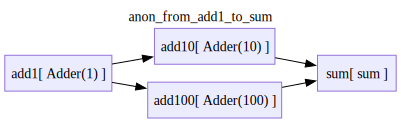

In [ ]:
A.draw(factored=True)

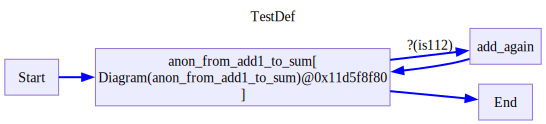

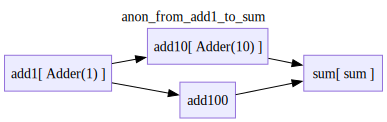

In [ ]:
a = A(add100=None)
# note that add100 doesnt have a function now since we overrode it
a.draw(factored=True)

In [ ]:
copy(a)

<__main__.Diagram>

## Export

In [ ]:
# |hide
import nbdev

nbdev.nbdev_export()